# Homework 05

## Group 10

This week we are taking a look at the CIFAR10 dataset. It contains 60.000 coloured images of cells with equal sizes. Each images corresponds to one of 10 categories. We want to train our network to classify these pictures. So let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Loading the dataset

We can load the dataset conviniently from Keras.

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [3]:
train_images[0].shape

(32, 32, 3)

Looking at the shape, we see that the image is 32x32 pixels with RGB color.

Let's take a look at the images, but we don't want to see the integers as labels, so we will use a little helper function to translate the labels into something a bit more understandable.

In [4]:
def class_names(label):
    """Little helper function to map a label to the corresponding word"""
    label_words = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return label_words[int(label)]

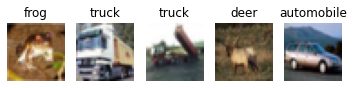

In [5]:
fig, ax = plt.subplots(1, 5)

for i in range(len(ax)):

    ax[i].imshow(train_images[i])
    ax[i].set_title(class_names(train_labels[i]))
    ax[i].axis("off")

# Input pipeline

Next onto our input pipeline. What we are doing here is pretty standard with a (mini-)batch-size of 64 and letting Tensorflow determine the prefetch size on the fly.

When it comes to preprocessing we have to do some reshaping for our network and we will also make sure to normalize our images and center them around zero.
After one-hot encoding our labels, we zip everything together in training and test dataset and are ready to move on.

In [6]:
# Input Pipeline

# Hyperparameters
batch_size = 64
prefetch_size = tf.data.experimental.AUTOTUNE

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

#we normalize our data and center the pixel values around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))


# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(prefetch_size)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))

test_dataset = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(prefetch_size)


## Optional: Data Augmentation

We added this later during our development process to get better generalization. When performing data augmentation, we are randomizing our input data. There are two ways you can go about it: Either you apply your augmentations directly to the dataset or you add it as an Keras preprocessing layer. To get a better understanding what you can do in terms of data augmentation and how to implement it, refer to the [tensorflow tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation) about it. We decided to go with the preprocessing layer, so we can take advantage of the GPU for it as well, as we are already training on GPU anyways.

# Building the model

As mentioned before, we integrated the data augmentation into the model itself.
We follow that up with six convolutional layers with increasing filters. We also used some regularization techniques. Regularization relies mainly on two principles: We do not want to rely too strongly on any single predictor and want to to rely on a broad range of predictors. They are used to avoid overfitting but also in some other contexts. 
So wich techniques did we use here? In between the blocks we placed pooling and dropout layers to minimize overfitting. Dropout is specifically used to avoid the neural network to depend too much on a single neuron. We therefore want to take all neurons into account. How? In each training step we exclude statistically chosen neurons from our network such that it learns to work well even without the excluded neurons. 
As you can see we also included batch normalization to normalize the drives of the neurons.For that it is important that the previous layer does not have an activation function but the activation function needs to be applied manually after the batch normalization layer.
Data augmentation is a also a regularization technique. So let's see what this looks like in our model. 
(We also tried using the l2 regularizer but since the model showed better performance without it we decided to stick with the other techniques for now)

In [7]:
from tensorflow.keras import layers

class Model(tf.keras.Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.layers_list = [
            # Our data augmentation
            layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(32,32,3)),
            layers.experimental.preprocessing.RandomRotation(0.1),
            layers.experimental.preprocessing.RandomZoom(0.1),
            
            #first block
            layers.Conv2D(32, kernel_size = (3,3), activation = None, padding = 'same', input_shape = (32,32,3)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(32, kernel_size = (3,3), activation = None),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size = (2,2)),
            layers.Dropout(0.20),
            
            #second block
            layers.Conv2D(64, kernel_size = (3,3), activation = None, padding = 'same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(64, kernel_size = (3,3), activation = None, padding = 'same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size = (2,2)),
            layers.Dropout(0.30),
            
            #third block
            layers.Conv2D(128, kernel_size = (3,3), activation = None, padding = 'same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.Conv2D(128, kernel_size = (3,3), activation = None, padding = 'same'),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(pool_size = (2,2)),
            
            layers.GlobalAveragePooling2D(),          
            layers.Dense(10, activation = 'softmax')
        ]
                                               
       
    def call(self, x, training = False):
        for layer in self.layers_list:
            x = layer(x, training = training)
        return x

In [8]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

# Training

We want to observe our models performance while training it, so to make the training cell not too cluttered we are going to use this helper function here which allows us to plot our performance every new epoch.

As a little bonus there is also a crude estimation how long the model still has to train, which is calculated based on how long the epoch took to train. Note that the timing is also only updated every epoch, so only take it as a rough guidance.

In [9]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()

We will train our network for 30 epochs with a learning rate of 0.001. As a loss we use categorical cross entropy and we chose Adam as our optimizer.

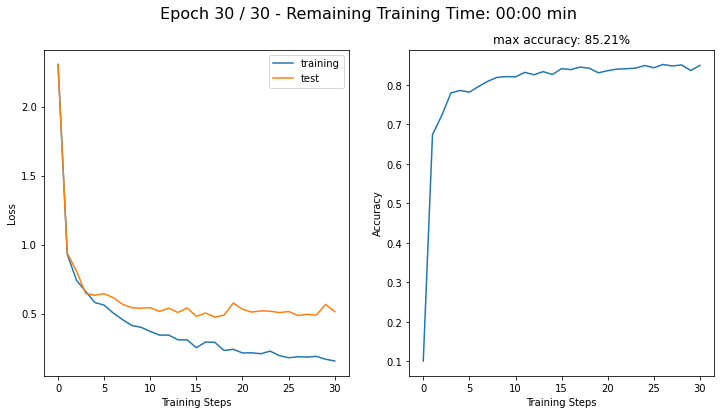

In [10]:
import time
%matplotlib inline
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    
    #print('Epoch: __ ' + str(epoch))
    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    end = time.perf_counter()
    plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))

As you can see our model has learnt to classify pictures from the Cifar10 dataset pretty well and we reached an accuracy of more than 85%. 